In [77]:
# Importing the libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, Dropout


import os 
import zipfile

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
#downloading the data
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /cats_and_dogs_filtered.zip

--2022-09-27 03:46:39--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.192.128, 172.217.219.128, 209.85.146.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.192.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/cats_and_dogs_filtered.zip’

/cats_and_dogs_filt 100%[===================>]  65.43M   185MB/s    in 0.4s    

2022-09-27 03:46:40 (185 MB/s) - ‘/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
# Unzipping the data
dataset_path = "/cats_and_dogs_filtered.zip"

zip_object = zipfile.ZipFile(file =dataset_path, mode="r")

zip_object.extractall("./")
zip_object.close()

In [4]:
#Creating directory
dataset_path_new = "/content/cats_and_dogs_filtered"

train_dir = os.path.join(dataset_path_new, "train")

valid_dir = os.path.join(dataset_path_new, "validation")

In [5]:
# Instantiating the Image data generator
data_gen_train = ImageDataGenerator(rescale=1/255)

data_gen_valid = ImageDataGenerator(rescale=1/255)

In [6]:
#Scaling the data
train_gen = data_gen_train.flow_from_directory(train_dir, target_size=(128,128),
                                               batch_size = 128, class_mode = "binary")

valid_gen = data_gen_train.flow_from_directory(valid_dir, target_size=(128,128),
                                               batch_size = 128, class_mode = "binary")

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [30]:
# Building the body of the model Using VGG19
base_model = tf.keras.applications.VGG19(input_shape=(128,128,3), weights="imagenet", include_top=False)

#freaaxing the layer
for layer in base_model.layers:
  layer.trainable= False

In [31]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [46]:
#Creating the Head of the model
model = Flatten()(base_model.output)

model = Dense(units=1024, activation="relu")(model)
model = Dense(units=200, activation="relu")(model)

prediction_layer = Dense(units=2, activation="softmax")(model)

In [47]:
# Joining the head and body
model = Model(inputs= base_model.input, outputs = prediction_layer)

In [48]:
#Summarising the model
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                                    

In [49]:
# Compiling and training 
model.compile(optimizer='adam', loss = "sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

model.fit_generator(train_gen, epochs=10, validation_data=valid_gen)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/10
16/16 [==============================] - 10s 555ms/step - loss: 6.2071 - sparse_categorical_accuracy: 0.7440 - val_loss: 0.7312 - val_sparse_categorical_accuracy: 0.9180
Epoch 2/10
16/16 [==============================] - 8s 509ms/step - loss: 0.3844 - sparse_categorical_accuracy: 0.9485 - val_loss: 0.3537 - val_sparse_categorical_accuracy: 0.9530
Epoch 3/10
16/16 [==============================] - 8s 516ms/step - loss: 0.0733 - sparse_categorical_accuracy: 0.9825 - val_loss: 0.1600 - val_sparse_categorical_accuracy: 0.9660
Epoch 4/10
16/16 [==============================] - 9s 566ms/step - loss: 0.0165 - sparse_categorical_accuracy: 0.9920 - val_loss: 0.1340 - val_sparse_categorical_accuracy: 0.9700
Epoch 5/10
16/16 [==============================] - 8s 516ms/step - loss: 0.0032 - sparse_categorical_accuracy: 0.9980 - val_loss: 0.1226 - val_sparse_categorical_accuracy: 0.9740
Epoch 6/10
16/16 [==============================] - 8s 512ms/step - loss: 0.0014 - sparse_categoric

Text(0.5, 1.0, 'Training-Validation Accuracy')

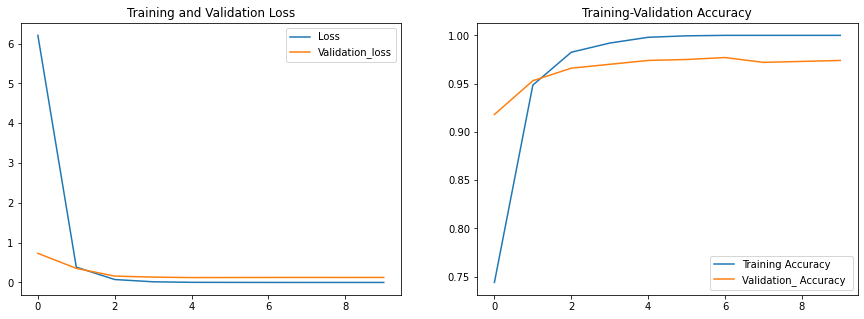

In [50]:
#saving the losses
loss = pd.DataFrame(model.history.history)

#plotting the loss and accuracy
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(loss["loss"], label ="Loss")
plt.plot(loss["val_loss"], label = "Validation_loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1,2,2)
plt.plot(loss['sparse_categorical_accuracy'],label = "Training Accuracy")
plt.plot(loss['val_sparse_categorical_accuracy'], label ="Validation_ Accuracy ")
plt.legend()
plt.title("Training-Validation Accuracy")

# Transfer learning Using Mobile Net architecture

In [51]:
# Building the body of the model Using VGG19
base_model = tf.keras.applications.MobileNet(input_shape=(128,128,3), weights="imagenet", include_top=False)

#freaaxing the layer
for layer in base_model.layers:
  layer.trainable= False

In [52]:
base_model.summary()

Model: "mobilenet_1.00_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                         

In [54]:
#Creating the Head of the model
model = Flatten()(base_model.output)

model = Dense(units=1024, activation="relu")(model)
model = Dense(units=200, activation="relu")(model)

prediction_layer = Dense(units=2, activation="softmax")(model)

In [55]:
# Joining the head and body
model = Model(inputs= base_model.input, outputs = prediction_layer)

In [56]:
#Summarising the model
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                                    

In [57]:
# Compiling and training 
model.compile(optimizer='adam', loss = "sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

model.fit_generator(train_gen, epochs=10, validation_data=valid_gen)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/10
16/16 [==============================] - 11s 569ms/step - loss: 2.9349 - sparse_categorical_accuracy: 0.8425 - val_loss: 0.4047 - val_sparse_categorical_accuracy: 0.9460
Epoch 2/10
16/16 [==============================] - 8s 516ms/step - loss: 0.1445 - sparse_categorical_accuracy: 0.9735 - val_loss: 0.1884 - val_sparse_categorical_accuracy: 0.9710
Epoch 3/10
16/16 [==============================] - 8s 510ms/step - loss: 0.0393 - sparse_categorical_accuracy: 0.9910 - val_loss: 0.2537 - val_sparse_categorical_accuracy: 0.9640
Epoch 4/10
16/16 [==============================] - 8s 513ms/step - loss: 0.0135 - sparse_categorical_accuracy: 0.9955 - val_loss: 0.1805 - val_sparse_categorical_accuracy: 0.9740
Epoch 5/10
16/16 [==============================] - 8s 515ms/step - loss: 0.0060 - sparse_categorical_accuracy: 0.9980 - val_loss: 0.1734 - val_sparse_categorical_accuracy: 0.9630
Epoch 6/10
16/16 [==============================] - 9s 571ms/step - loss: 0.0010 - sparse_categoric

Text(0.5, 1.0, 'Training-Validation Accuracy')

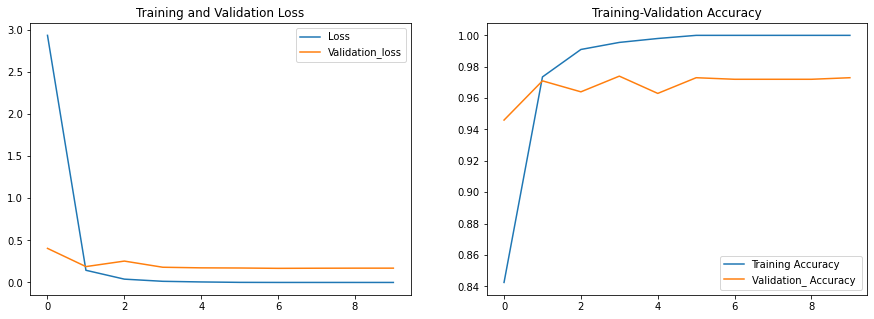

In [58]:
#saving the losses
loss = pd.DataFrame(model.history.history)

#plotting the loss and accuracy
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(loss["loss"], label ="Loss")
plt.plot(loss["val_loss"], label = "Validation_loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1,2,2)
plt.plot(loss['sparse_categorical_accuracy'],label = "Training Accuracy")
plt.plot(loss['val_sparse_categorical_accuracy'], label ="Validation_ Accuracy ")
plt.legend()
plt.title("Training-Validation Accuracy")

In [62]:
# Transfer learning Using VGG16 architecture



In [63]:
# Building the body of the model Using VGG16
base_model = tf.keras.applications.VGG16(input_shape=(128,128,3), weights="imagenet", include_top=False)

#freaaxing the layer
for layer in base_model.layers:
  layer.trainable= False

58900480/58889256 [==============================] - 0s 0us/step


In [66]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [73]:
#Creating the Head of the model
model = Flatten()(base_model.output)

model = Dense(units=1024, activation="relu")(model)
model = Dense(units=200, activation="relu")(model)

prediction_layer = Dense(units=2, activation="softmax")(model)

In [84]:
model = Model(inputs= base_model.input, outputs = prediction_layer)

In [85]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [86]:
model.compile(optimizer='adam', loss = "sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

In [87]:
model.fit_generator(train_gen, epochs=10, validation_data=valid_gen)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/10
16/16 [==============================] - 10s 593ms/step - loss: 1.4856 - sparse_categorical_accuracy: 0.6705 - val_loss: 0.4167 - val_sparse_categorical_accuracy: 0.8070
Epoch 2/10
16/16 [==============================] - 9s 578ms/step - loss: 0.3184 - sparse_categorical_accuracy: 0.8625 - val_loss: 0.3201 - val_sparse_categorical_accuracy: 0.8530
Epoch 3/10
16/16 [==============================] - 9s 586ms/step - loss: 0.2343 - sparse_categorical_accuracy: 0.8990 - val_loss: 0.3092 - val_sparse_categorical_accuracy: 0.8640
Epoch 4/10
16/16 [==============================] - 9s 577ms/step - loss: 0.1697 - sparse_categorical_accuracy: 0.9330 - val_loss: 0.2844 - val_sparse_categorical_accuracy: 0.8850
Epoch 5/10
16/16 [==============================] - 9s 550ms/step - loss: 0.1374 - sparse_categorical_accuracy: 0.9490 - val_loss: 0.3356 - val_sparse_categorical_accuracy: 0.8580
Epoch 6/10
16/16 [==============================] - 9s 551ms/step - loss: 0.1075 - sparse_categoric

Text(0.5, 1.0, 'Training-Validation Accuracy')

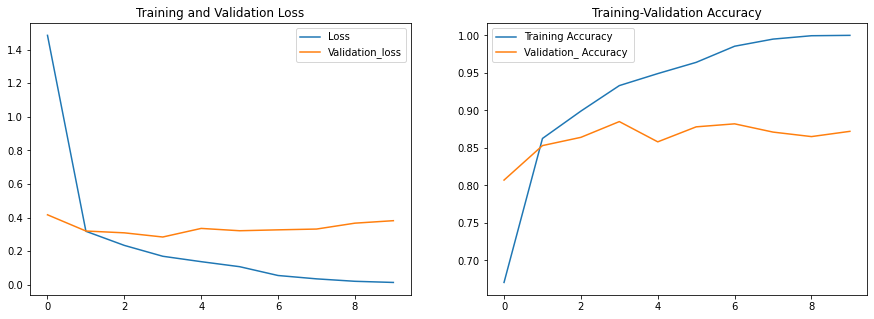

In [88]:
#saving the losses
loss = pd.DataFrame(model.history.history)

#plotting the loss and accuracy
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(loss["loss"], label ="Loss")
plt.plot(loss["val_loss"], label = "Validation_loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1,2,2)
plt.plot(loss['sparse_categorical_accuracy'],label = "Training Accuracy")
plt.plot(loss['val_sparse_categorical_accuracy'], label ="Validation_ Accuracy ")
plt.legend()
plt.title("Training-Validation Accuracy")

In [89]:
# Transfer learning Using Resnet50 architecture


In [90]:
# Building the body of the model Using Resnet50
base_model = tf.keras.applications.ResNet50(input_shape=(128,128,3), weights="imagenet", include_top=False)

#freaaxing the layer
for layer in base_model.layers:
  layer.trainable= False

94781440/94765736 [==============================] - 1s 0us/step


In [91]:
#Creating the Head of the model
model = Flatten()(base_model.output)

model = Dense(units=1024, activation="relu")(model)
model = Dense(units=200, activation="relu")(model)

prediction_layer = Dense(units=2, activation="softmax")(model)

In [92]:
model = Model(inputs= base_model.input, outputs = prediction_layer)

In [93]:
model.compile(optimizer='adam', loss = "sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

In [94]:
model.fit_generator(train_gen, epochs=10, validation_data=valid_gen)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/10
16/16 [==============================] - 16s 777ms/step - loss: 1.0549 - sparse_categorical_accuracy: 0.5395 - val_loss: 0.6707 - val_sparse_categorical_accuracy: 0.5800
Epoch 2/10
16/16 [==============================] - 9s 537ms/step - loss: 0.6673 - sparse_categorical_accuracy: 0.5765 - val_loss: 0.6528 - val_sparse_categorical_accuracy: 0.6010
Epoch 3/10
16/16 [==============================] - 9s 560ms/step - loss: 0.6490 - sparse_categorical_accuracy: 0.6240 - val_loss: 0.6440 - val_sparse_categorical_accuracy: 0.6080
Epoch 4/10
16/16 [==============================] - 8s 529ms/step - loss: 0.6322 - sparse_categorical_accuracy: 0.6365 - val_loss: 0.6366 - val_sparse_categorical_accuracy: 0.6190
Epoch 5/10
16/16 [==============================] - 8s 530ms/step - loss: 0.6309 - sparse_categorical_accuracy: 0.6370 - val_loss: 0.6347 - val_sparse_categorical_accuracy: 0.6330
Epoch 6/10
16/16 [==============================] - 10s 627ms/step - loss: 0.6039 - sparse_categori

Text(0.5, 1.0, 'Training-Validation Accuracy')

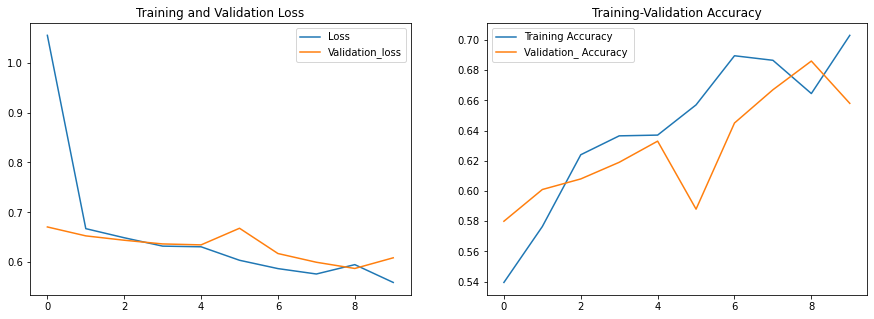

In [95]:
#saving the losses
loss = pd.DataFrame(model.history.history)

#plotting the loss and accuracy
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(loss["loss"], label ="Loss")
plt.plot(loss["val_loss"], label = "Validation_loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1,2,2)
plt.plot(loss['sparse_categorical_accuracy'],label = "Training Accuracy")
plt.plot(loss['val_sparse_categorical_accuracy'], label ="Validation_ Accuracy ")
plt.legend()
plt.title("Training-Validation Accuracy")

In [96]:
# # Transfer learning Using InceptionV3 architecture

In [105]:
# Building the body of the model Using Inception v3
base_model = tf.keras.applications.InceptionV3(input_shape=(128,128,3), weights="imagenet", include_top=False)

#freaaxing the layer
for layer in base_model.layers:
  layer.trainable= False

87924736/87910968 [==============================] - 1s 0us/step


In [106]:
#Creating the Head of the model
model = Flatten()(base_model.output)

model = Dense(units=1024, activation="relu")(model)
model = Dense(units=200, activation="relu")(model)

prediction_layer = Dense(units=2, activation="softmax")(model)

In [107]:
model = Model(inputs= base_model.input, outputs = prediction_layer)

In [108]:
model.compile(optimizer='adam', loss = "sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

In [109]:
model.fit_generator(train_gen, epochs=10, validation_data=valid_gen)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/10
16/16 [==============================] - 18s 800ms/step - loss: 8.6457 - sparse_categorical_accuracy: 0.6195 - val_loss: 0.6026 - val_sparse_categorical_accuracy: 0.8650
Epoch 2/10
16/16 [==============================] - 8s 521ms/step - loss: 0.7213 - sparse_categorical_accuracy: 0.8805 - val_loss: 0.6598 - val_sparse_categorical_accuracy: 0.8920
Epoch 3/10
16/16 [==============================] - 8s 528ms/step - loss: 0.3528 - sparse_categorical_accuracy: 0.9145 - val_loss: 0.3432 - val_sparse_categorical_accuracy: 0.9080
Epoch 4/10
16/16 [==============================] - 8s 521ms/step - loss: 0.2419 - sparse_categorical_accuracy: 0.9295 - val_loss: 0.2682 - val_sparse_categorical_accuracy: 0.9130
Epoch 5/10
16/16 [==============================] - 8s 512ms/step - loss: 0.1350 - sparse_categorical_accuracy: 0.9495 - val_loss: 0.2141 - val_sparse_categorical_accuracy: 0.9170
Epoch 6/10
16/16 [==============================] - 8s 513ms/step - loss: 0.0993 - sparse_categoric

Text(0.5, 1.0, 'Training-Validation Accuracy')

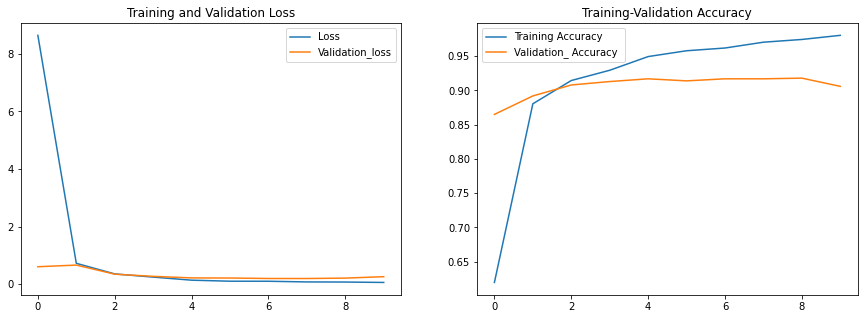

In [110]:
#saving the losses
loss = pd.DataFrame(model.history.history)

#plotting the loss and accuracy
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(loss["loss"], label ="Loss")
plt.plot(loss["val_loss"], label = "Validation_loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1,2,2)
plt.plot(loss['sparse_categorical_accuracy'],label = "Training Accuracy")
plt.plot(loss['val_sparse_categorical_accuracy'], label ="Validation_ Accuracy ")
plt.legend()
plt.title("Training-Validation Accuracy")

In [111]:
# # Transfer learning Using MobileNetV2 architecture



In [118]:
# Building the body of the model Using MobileNetV2
base_model = tf.keras.applications.MobileNetV2(input_shape=(128,128,3), weights="imagenet", include_top=False)

#freaaxing the layer
for layer in base_model.layers:
  layer.trainable= False

In [119]:
#Creating the Head of the model
model = Flatten()(base_model.output)

model = Dense(units=1024, activation="relu")(model)
model = Dense(units=200, activation="relu")(model)

prediction_layer = Dense(units=2, activation="softmax")(model)

In [120]:
model = Model(inputs= base_model.input, outputs = prediction_layer)

In [121]:
model.compile(optimizer='adam', loss = "sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

In [117]:
model.fit_generator(train_gen, epochs=10, validation_data=valid_gen)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/10
16/16 [==============================] - 12s 580ms/step - loss: 1.2315 - sparse_categorical_accuracy: 0.8830 - val_loss: 0.3001 - val_sparse_categorical_accuracy: 0.9440
Epoch 2/10
16/16 [==============================] - 8s 489ms/step - loss: 0.1220 - sparse_categorical_accuracy: 0.9695 - val_loss: 0.1774 - val_sparse_categorical_accuracy: 0.9670
Epoch 3/10
16/16 [==============================] - 8s 494ms/step - loss: 0.0672 - sparse_categorical_accuracy: 0.9825 - val_loss: 0.1426 - val_sparse_categorical_accuracy: 0.9710
Epoch 4/10
16/16 [==============================] - 8s 505ms/step - loss: 0.0264 - sparse_categorical_accuracy: 0.9920 - val_loss: 0.2361 - val_sparse_categorical_accuracy: 0.9680
Epoch 5/10
16/16 [==============================] - 8s 495ms/step - loss: 0.0059 - sparse_categorical_accuracy: 0.9980 - val_loss: 0.1849 - val_sparse_categorical_accuracy: 0.9760
Epoch 6/10
16/16 [==============================] - 8s 498ms/step - loss: 0.0066 - sparse_categoric

Text(0.5, 1.0, 'Training-Validation Accuracy')

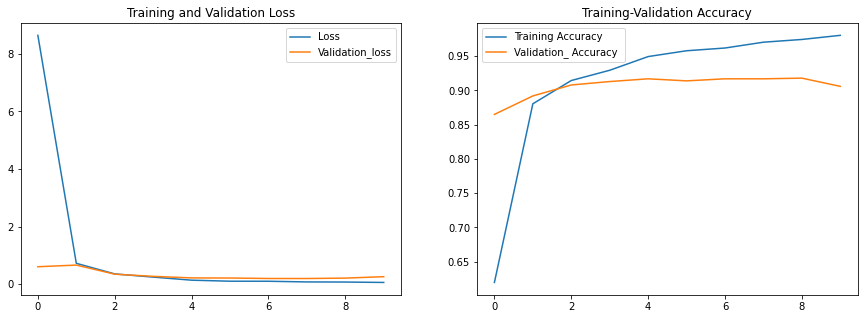

In [130]:
#saving the losses
#loss = pd.DataFrame(model.history.history)

#plotting the loss and accuracy
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(loss["loss"], label ="Loss")
plt.plot(loss["val_loss"], label = "Validation_loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1,2,2)
plt.plot(loss['sparse_categorical_accuracy'],label = "Training Accuracy")
plt.plot(loss['val_sparse_categorical_accuracy'], label ="Validation_ Accuracy ")
plt.legend()
plt.title("Training-Validation Accuracy")
